In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0098.hk',"2017-09-28","2021-09-24")
data.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].pct_change(7)
data['7day MA'] = data['Close'].shift(1).rolling(window = 7).mean()
data['14day MA'] = data['Close'].shift(1).rolling(window = 14).mean()
data['21day MA'] = data['Close'].shift(1).rolling(window = 21).mean()
data['Std_dev']= data['Close'].shift(1).rolling(7).std()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,7day MA,14day MA,21day MA,Std_dev
Date,,,,,,,,,,,,,
2017-09-28,4.81,4.81,4.63,4.68,3.973988,237000,0.180000,-0.130000,NaN,NaN,NaN,NaN,NaN
2017-09-29,4.76,4.80,4.66,4.68,3.973988,98000,0.140000,-0.080000,NaN,NaN,NaN,NaN,NaN
2017-10-03,4.72,5.14,4.72,5.13,4.356103,277000,0.420000,0.410000,NaN,NaN,NaN,NaN,NaN
2017-10-04,5.25,5.30,5.17,5.25,4.458001,228000,0.130000,0.000000,NaN,NaN,NaN,NaN,NaN
2017-10-06,5.25,5.25,5.19,5.19,4.407052,31000,0.060000,-0.060000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16,11.40,11.40,11.40,11.40,11.400000,3000,0.000000,0.000000,-0.088000,12.048571,12.372857,12.546667,0.370739
2021-09-17,11.40,11.40,10.60,11.24,11.240000,66000,0.799999,-0.160000,-0.089141,11.891428,12.271428,12.472381,0.380501
2021-09-20,11.02,11.18,10.26,11.18,11.180000,43000,0.920000,0.160000,-0.083607,11.734285,12.158571,12.393333,0.391359


In [4]:
data.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
H-L           0
O-C           0
% Change      7
7day MA       7
14day MA     14
21day MA     21
Std_dev       7
dtype: int64

In [5]:
data.dropna(inplace=True,axis=0)
data

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,7day MA,14day MA,21day MA,Std_dev
Date,,,,,,,,,,,,,
2017-10-31,5.67,5.79,5.63,5.79,4.916537,176000,0.160000,0.120000,-0.050820,5.961429,5.889286,5.618095,0.136800
2017-11-01,5.70,5.72,5.38,5.68,4.823131,158000,0.340000,-0.020000,-0.053333,5.917143,5.924286,5.670952,0.134625
2017-11-02,5.62,5.93,5.62,5.88,4.992960,258000,0.310000,0.260000,-0.016722,5.871428,5.940714,5.718571,0.154642
2017-11-03,5.87,6.02,5.87,5.99,5.086366,226000,0.150000,0.120000,-0.008278,5.857143,5.925000,5.754286,0.147390
2017-11-06,5.97,6.05,5.95,6.00,5.094857,746000,0.100000,0.030000,0.005025,5.850000,5.931429,5.789524,0.137961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16,11.40,11.40,11.40,11.40,11.400000,3000,0.000000,0.000000,-0.088000,12.048571,12.372857,12.546667,0.370739
2021-09-17,11.40,11.40,10.60,11.24,11.240000,66000,0.799999,-0.160000,-0.089141,11.891428,12.271428,12.472381,0.380501
2021-09-20,11.02,11.18,10.26,11.18,11.180000,43000,0.920000,0.160000,-0.083607,11.734285,12.158571,12.393333,0.391359


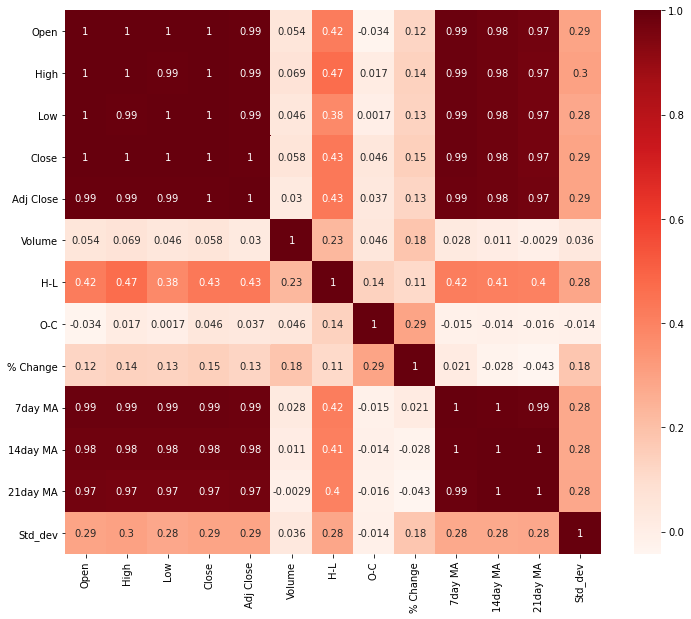

In [6]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
#Correlation with output variable
cor_target = abs(cor["Close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Open         0.996770
High         0.997887
Low          0.997007
Close        1.000000
Adj Close    0.995365
7day MA      0.989535
14day MA     0.980282
21day MA     0.971215
Name: Close, dtype: float64

In [8]:
# print(data[["RSI","Williams %R"]].corr())

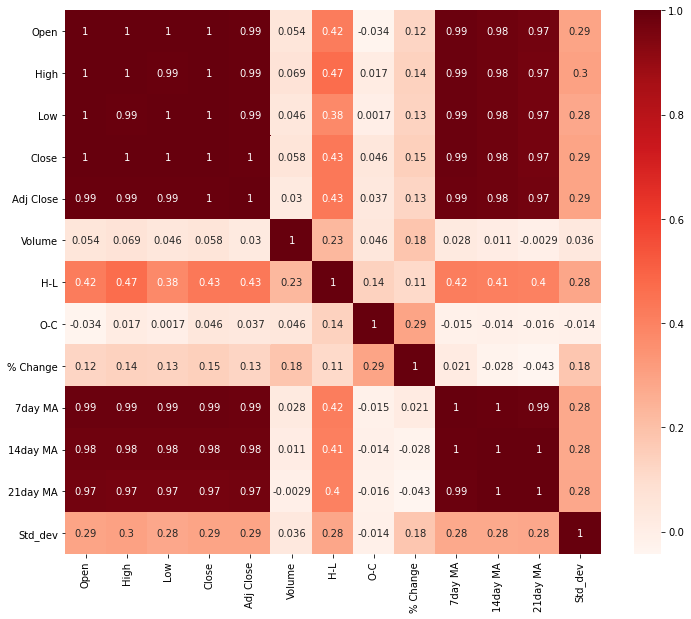

In [9]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
correlated_features = cor[cor>0.1].index.tolist()
corr_matrix = data[correlated_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

Best alpha using built-in LassoCV: 0.100000
Best score using built-in LassoCV: 0.996279
Lasso picked 11 variables and eliminated the other 0 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

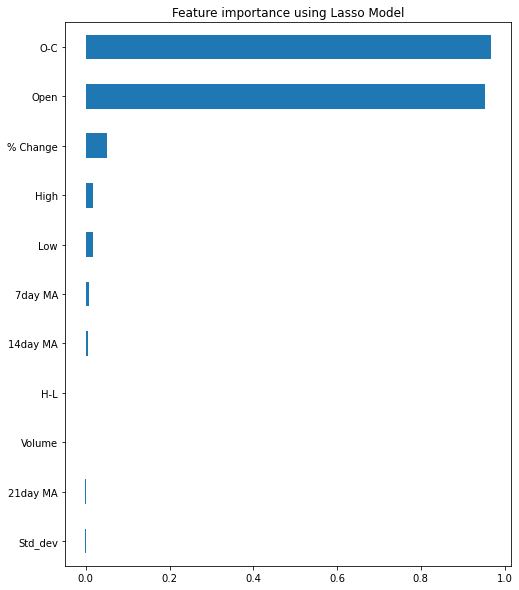

In [10]:
features = ["Open","High","Low","Close","Volume","H-L","O-C","7day MA","14day MA","21day MA","Std_dev"]
X=data.drop(["Close","Adj Close"],1)
y=data['Close']
reg = RidgeCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [11]:
data.drop("Volume",1)

,Open,High,Low,Close,Adj Close,H-L,O-C,% Change,7day MA,14day MA,21day MA,Std_dev
Date,,,,,,,,,,,,
2017-10-31,5.67,5.79,5.63,5.79,4.916537,0.160000,0.120000,-0.050820,5.961429,5.889286,5.618095,0.136800
2017-11-01,5.70,5.72,5.38,5.68,4.823131,0.340000,-0.020000,-0.053333,5.917143,5.924286,5.670952,0.134625
2017-11-02,5.62,5.93,5.62,5.88,4.992960,0.310000,0.260000,-0.016722,5.871428,5.940714,5.718571,0.154642
2017-11-03,5.87,6.02,5.87,5.99,5.086366,0.150000,0.120000,-0.008278,5.857143,5.925000,5.754286,0.147390
2017-11-06,5.97,6.05,5.95,6.00,5.094857,0.100000,0.030000,0.005025,5.850000,5.931429,5.789524,0.137961
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16,11.40,11.40,11.40,11.40,11.400000,0.000000,0.000000,-0.088000,12.048571,12.372857,12.546667,0.370739
2021-09-17,11.40,11.40,10.60,11.24,11.240000,0.799999,-0.160000,-0.089141,11.891428,12.271428,12.472381,0.380501
2021-09-20,11.02,11.18,10.26,11.18,11.180000,0.920000,0.160000,-0.083607,11.734285,12.158571,12.393333,0.391359


In [12]:
def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
def build_timeseries(mat, y_col_index):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

train_cols = ["Close","H-L","O-C","7day MA","14day MA","21day MA","% Change"]
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 30
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
x_t, y_t = build_timeseries(x_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
# print(x_test.shape)
print("Batch trimmed size", x_t.shape, y_t.shape)

Train--Test size 701 176
Length of inputs 671
length of time-series - inputs (671, 30, 7)
length of time-series - outputs (671,)
Batch trimmed size (660, 30, 7) (660,)


In [13]:
'''Step 9 - Construct customized loss function for training'''
def custom_loss(y_true, y_pred):
    
    #extract the "next day's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "today's price" of tensor
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    print('Shape of y_pred_back -', y_pred_tdy.get_shape())
    
    #substract to get up/down movement of the two tensors
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    indices = tf.where(condition)

    #move one position later
    ones = tf.ones_like(indices)
    indices = tf.add(indices, ones)
    indices = K.cast(indices, dtype='int32')
    
    
    #create a tensor to store directional loss and put it into custom loss output
    direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
    updates = K.cast(tf.ones_like(indices), dtype='float32')
    alpha = 1000
    direction_loss = tf.compat.v1.scatter_nd_update(direction_loss, indices, alpha*updates)
    
    custom_loss = K.mean(tf.multiply(K.square(y_true - y_pred), direction_loss), axis=-1)
    
    return custom_loss

In [14]:
'''Step 10 - Build LSTM model'''

def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0,
                        stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(100, dropout=0.0))
    lstm_model.add(Dropout(0.2))
    
#     lstm_model.add(Dense(32))
    lstm_model.add(Dense(1))
        
    #compile the model
    optimizer = Adam(lr=params["lr"])
    lstm_model.compile(loss=custom_loss, optimizer=optimizer)
  
    return lstm_model

lstm_model = None

In [15]:
# lstm_model = Sequential()
#     # (batch_size, timesteps, data_dim)
# lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
#                     dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
#                     kernel_initializer='random_uniform'))
# # lstm_model.add(Dropout(0.4))
# lstm_model.add(LSTM(60, dropout=0.0))
# # lstm_model.add(Dropout(0.4))
# lstm_model.add(Dense(20,activation='relu'))
# lstm_model.add(Dense(1,activation='sigmoid'))
# optimizer = RMSprop(learning_rate=params["lr"])
# # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
# lstm_model.compile(loss=custom_loss, optimizer=optimizer)

In [16]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

Length of inputs 146
length of time-series - inputs (146, 30, 7)
length of time-series - outputs (146,)


In [17]:
lstm_model = create_lstm_model()
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (20, 30, 100)             43200     
_________________________________________________________________
dropout (Dropout)            (20, 30, 100)             0         
_________________________________________________________________
lstm_1 (LSTM)                (20, 100)                 80400     
_________________________________________________________________
dropout_1 (Dropout)          (20, 100)                 0         
_________________________________________________________________
dense (Dense)                (20, 1)                   101       
Total params: 123,701
Trainable params: 123,701
Non-trainable params: 0
_________________________________________________________________
None


/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:357: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = lstm_model.fit(x_t, y_t, epochs=params["epochs"], batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)))

Epoch 1/300
Shape of y_pred_back - (19, 1)
33/33 [==============================] - ETA: 0s - loss: 23.0770Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
33/33 [==============================] - 3s 71ms/step - loss: 23.2443 - val_loss: 2.4864
Epoch 2/300
Shape of y_pred_back - (19, 1)
33/33 [==============================] - ETA: 0s - loss: 20.5474Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
33/33 [==============================] - 2s 70ms/step - loss: 20.3827 - val_loss: 3.5797
Epoch 3/300
Shape of y_pred_back - (19, 1)
33/33 [==============================] - ETA: 0s - loss: 10.6517Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
33/33 [==============================] - 2s 70ms/step - loss: 10.6225 - val_loss: 3.1369
Epoch 4/300
Shape of y_pred_back - (19, 1)
33/33 [==============================] - ETA: 0s - loss: 8.6056Shape of y_pred_back - (19,

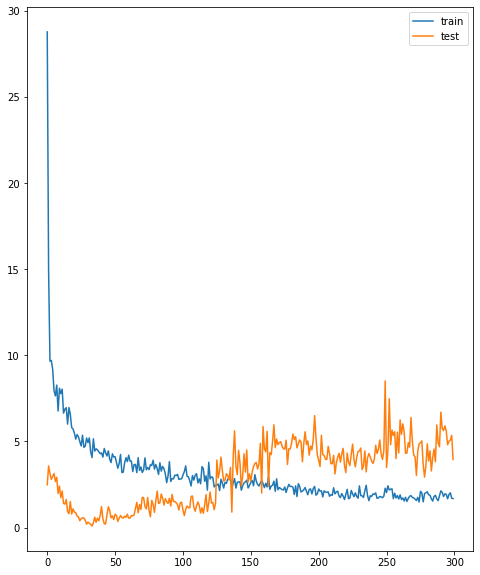

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [20]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.1784172304220592 (60,) (60,)
[1.5267597 1.562487  1.5256594 1.5134754 1.519216  1.5840535 1.592275
 1.563967  1.5811282 1.6129516 1.6652944 1.6743557 1.6490548 1.6578286
 1.6659534]
[1.93440119 1.94813116 1.94660561 1.9435545  1.9366895  1.9504195
 1.96643781 1.97406557 1.99771164 2.03127377 2.07398925 2.11670473
 2.14111355 2.16247131 2.19527068]
[10.968645  11.113697  10.964177  10.91471   10.938017  11.201258
 11.234636  11.119705  11.189381  11.3185835 11.5310955 11.567884
 11.465162  11.500784  11.533771 ]
[12.62366872 12.67941237 12.67321863 12.66083115 12.63295925 12.68870305
 12.75373739 12.78470608 12.88070911 13.01697137 13.19039621 13.36382105
 13.46292088 13.54963337 13.68279884]


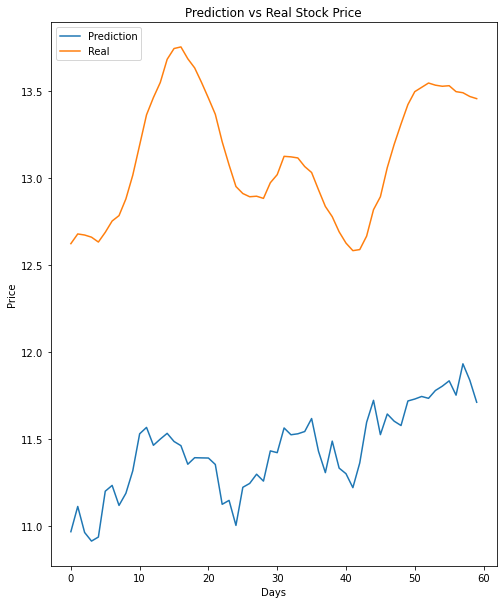

In [21]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

In [22]:
mean_absolute_percentage_error(y_pred_org,y_test_t_org)*100

14.811261621776975

In [23]:
mean_squared_error(y_pred_org,y_test_t_org)

2.9409582281200426

In [24]:
from sklearn.metrics import accuracy_score
y_pred_lstm_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)

print(y_pred_lstm_org[0:15])
print(y_test_t_org[0:15])

y_test_t_final = np.zeros((len(y_test_t_org)-1,))
y_pred_lstm_final = np.zeros((len(y_pred)-1,))

#convert prediction into binary output (up or down movement)
for i in range(len(y_pred_lstm_org)-1):
    if y_pred_lstm_org[i+1] >= y_pred_lstm_org[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test_t_org)-1):
    if y_test_t_org[i+1] >= y_test_t_org[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[10.567377 10.701201 10.563255 10.517618 10.53912  10.781983 10.812778
 10.706745 10.771027 10.890227 11.086288 11.12023  11.025459 11.058324
 11.088757]
[12.09428583 12.14571435 12.14000007 12.12857151 12.10285718 12.15428584
 12.21428585 12.24285725 12.33142866 12.45714283 12.61714281 12.7771428
 12.86857128 12.94857134 13.07142844]
[1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.]
[1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predicted direction accuracy (Up/down):
0.6440677966101694
